# 1. Dataset process


In [1]:
import zipfile
extract_path = '/home/s5604009/imageextraction/data_download/Person detection.v16i.coco.zip'

with zipfile.ZipFile(extract_path, 'r') as zip_ref:
     zip_ref.extractall('/home/s5604009/imageextraction/data/DP')
     #tar.extractall('/transfer/jingyao')

In [96]:
import json
import csv
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [97]:
def parse_coco_single_person(json_file, csv_file):
    with open(json_file) as f:
        data = json.load(f)

    images = {item['id']: item for item in data['images']}
    annotations = [ann for ann in data['annotations'] if ann['category_id'] == 1]  # Assuming category_id 1 is for person

    # Filtering for images with only one person
    single_person_images = {}
    for ann in annotations:
        image_id = ann['image_id']
        if image_id in single_person_images:
            single_person_images[image_id].append(ann)
        else:
            single_person_images[image_id] = [ann]

    single_person_images = {k: v for k, v in single_person_images.items() if len(v) == 1}

    # Writing to CSV
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['image_id', 'file_name', 'width', 'height', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height'])

        for image_id, anns in single_person_images.items():
            ann = anns[0]
            image = images[image_id]
            bbox = ann['bbox']
            # Write to CSV
            writer.writerow([image_id, image['file_name'], image['width'], image['height'], *bbox])

In [98]:
json_file_path = '/home/s5604009/imageextraction/data/DP/train/_annotations.coco.json'
csv_file_path = '/home/s5604009/imageextraction/data/DP/single_person_annotations.csv'

parse_coco_single_person(json_file_path, csv_file_path)

pd.read_csv('data/DP/single_person_annotations.csv')

image_id                                          file_name  width  \
0            1  casa_1_mp4-152_jpg.rf.c8b7090261fb3842deeca1f4...    640   
1            3  photo-1618661110516-3d6e96639ee2_jpg.rf.c913a5...    640   
2            5  casa_1_mp4-68_jpg.rf.c94066ce476363b34f9c96dfa...    640   
3            6  photo-1520774779505-a7782b3fb733_jpg.rf.c9511e...    640   
4            7  photo-1491609154219-ffd3ffafd992_jpg.rf.c95273...    640   
...        ...                                                ...    ...   
2668      4400  photo-1579453316158-ab4918060bee_jpg.rf.29a271...    640   
2669      4402  profile-fb-1504885936-79d2f2c00c50_jpg.rf.296f...    640   
2670      4403  00OVERCROWDING1-articleLarge_jpg.rf.298afbecff...    640   
2671      4404  photo-1500832333538-837287aad2b6_jpg.rf.2937e1...    640   
2672      4406  premium_photo-1663012928763-776df093d238_jpg.r...    640   

      height  bbox_x  bbox_y  bbox_width  bbox_height  
0        640     281     188       170.0        451.5  
1        640      98     253       260.0        128.0  
2        640     249     184       391.0        180.0  
3        640     203      36       271.0        498.0  
4        640     310     230        90.5        145.5  
...      ...     ...     ...         ...          ...  
2668     640       3     169       575.0        471.0  
2669     640       0       2       640.0        528.0  
2670     640     321     169        67.0        246.0  
2671     640      22       0       618.0        630.0  
2672     640      40     267       402.0        150.0  

[2673 rows x 8 columns]

# Subclassing Dataset

In [99]:
from torch.utils.data import Dataset

class DBDataset(Dataset):
    def __init__(self, filepath: str): 
        super().__init__()
        self.dataframe = pd.read_csv(filepath)[:2670] # Load data from CSV filepath defined earlier into a Pandas dataframe
    
    def __len__(self):
        return len(self.dataframe) # Return size of our dataframe
        
    def __getitem__(self, i):
        return self.dataframe.iloc[i] # Return the `i`th item in our dataframe    

# Data Loader

In [100]:
import multiprocessing as mp
from torch.utils.data import DataLoader,random_split
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


def load_image_tensor(filepath, threshold):
    img = Image.open(filepath)
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    img_tensor = transform(img)
    img_tensor = torch.where(img_tensor<threshold, 0, img_tensor) 
    return img_tensor.reshape(1,3,640,640)

In [101]:
def custom_collate_fn(batch):
    image_batch_tensor = torch.FloatTensor(len(batch),3, 640, 640) 
    image_tensors = []
    labels = []
    for item in batch:
        image_tensor = load_image_tensor(f"/home/s5604009/imageextraction/data/DP/train/{item.iloc[1]}", threshold=50) # load a single image
        image_tensors.append(image_tensor / 255) # put image into a list 
        labels.append([(item.iloc[4])/640,(item.iloc[5])/640,(item.iloc[4]+item.iloc[6])/640,(item.iloc[5]+item.iloc[7])/640]) # put the same image's label into another list



    torch.cat(image_tensors, out=image_batch_tensor) # torch.cat simply concatenates a list of individual tensors (image_tensors) into a single Pytorch tensor (image_batch_tensor)
    label_batch_tensor = torch.tensor(labels) # use the label list to create a torch tensor of ints
    return (image_batch_tensor, label_batch_tensor)


In [102]:
def load_data(data_path, batch_sz=100, train_val_test_split=[0.6, 0.2, 0.2]):
    dataset = DBDataset(data_path)  # Instantiating previously defined dataset
    
    # generates the actual number of items that goes into each split using the user-supplied fractions
    tr_va_te = []
    for frac in train_val_test_split:
        actual_count = frac * len(dataset)
        actual_count = round(actual_count)
        tr_va_te.append(actual_count)
    
    # split dataset into train, val and test
    train_split, val_split, test_split = random_split(dataset, tr_va_te)
    
    
    # data and load it. num_workers tells the DataLoader how many CPU threads to use so that data can be loaded in parallel, which is faster
    n_cpus = mp.cpu_count() # returns number of CPU cores on this machine
    train_dl = DataLoader(train_split, 
                          batch_size=batch_sz, 
                          shuffle=True, 
                          collate_fn=custom_collate_fn,
                          num_workers=n_cpus)            
    val_dl = DataLoader(val_split, 
                        batch_size=batch_sz, 
                        shuffle=True, 
                        collate_fn=custom_collate_fn,
                        num_workers=n_cpus)
    test_dl = DataLoader(test_split,
                         batch_size=batch_sz,
                         shuffle=False,
                         collate_fn=custom_collate_fn,
                         num_workers=n_cpus)
    return train_dl, val_dl, test_dl



In [103]:
DATA_PATH = '/home/s5604009/imageextraction/data/DP/single_person_annotations.csv'


train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=64)

train_images, _ = next(iter(train_dl))
test_images, test_labels = next(iter(test_dl))

# Visualing training data and testing data

In [104]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision
from PIL import Image



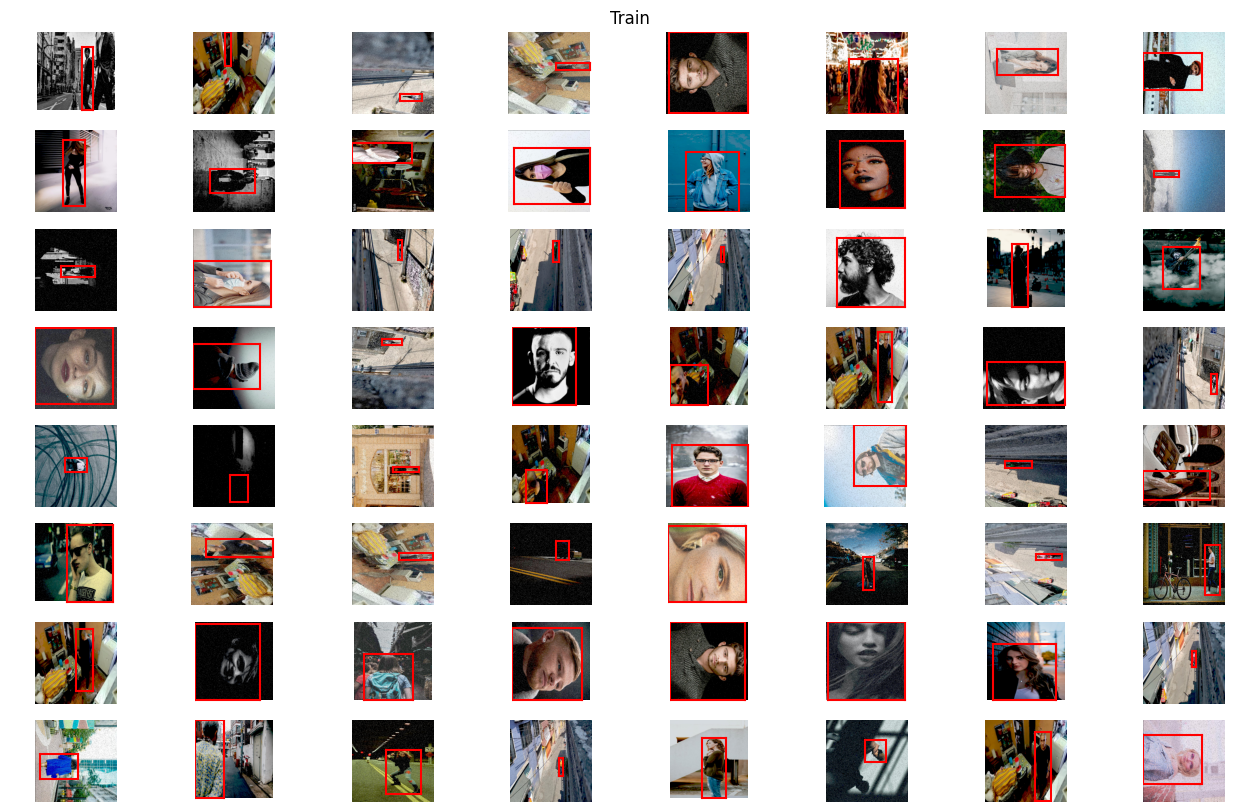

In [105]:
plt.figure(figsize=[16,10])
selected_batch = next(iter(train_dl))
plt.axis('off')
plt.title("Train")
for i in range(64):
    plt.subplot(8,8,i+1)

    image = selected_batch[0][i].permute(1, 2, 0)
    bbox = selected_batch[1][i]
    plt.imshow(image)


    xmin, ymin, xmax, ymax = bbox*640

    
    plt.plot([xmin,xmax],[ymax,ymax],c="r")
    plt.plot([xmin,xmax],[ymin,ymin],c="r")
    plt.plot([xmin,xmin],[ymin,ymax],c="r")
    plt.plot([xmax,xmax],[ymin,ymax],c="r")
    plt.axis("off")



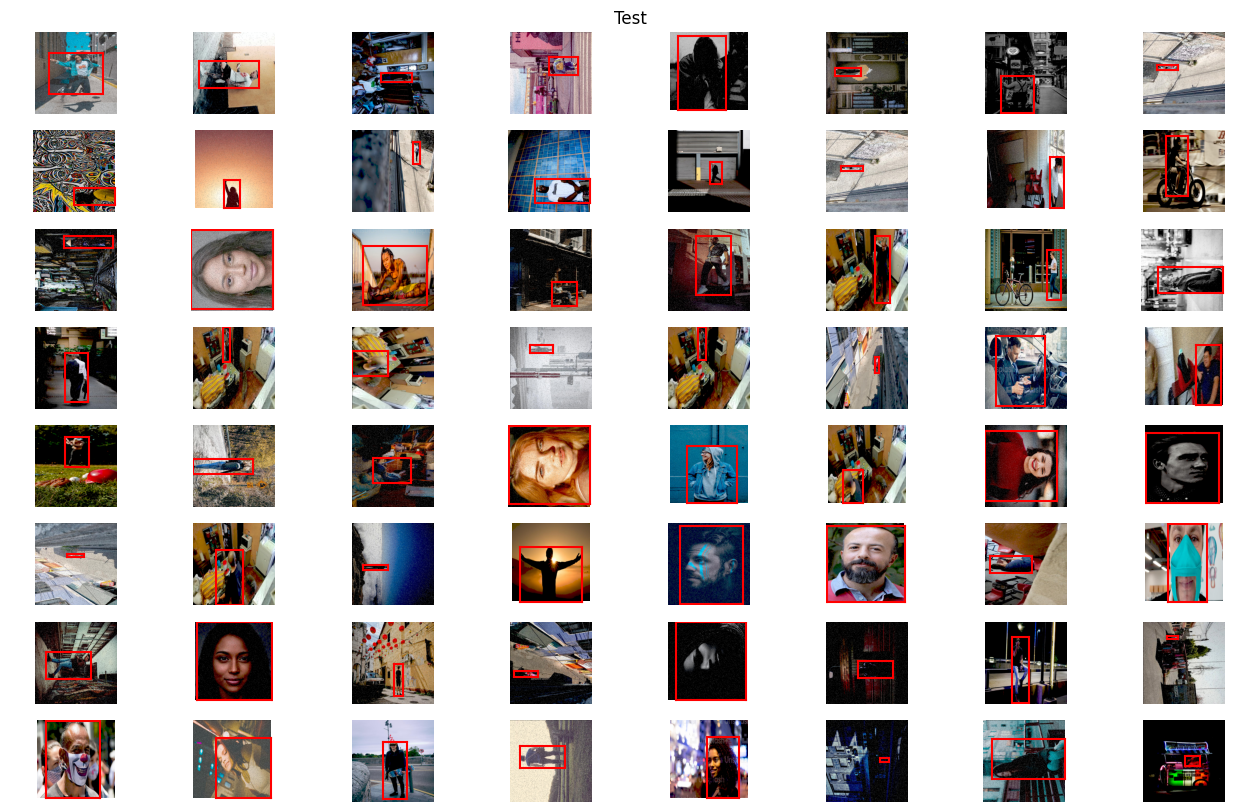

In [106]:
plt.figure(figsize=[16,10])
selected_batch = next(iter(test_dl))
plt.axis('off')
plt.title("Test")
for i in range(64):
    plt.subplot(8,8,i+1)

    image = selected_batch[0][i].permute(1, 2, 0)
    bbox = selected_batch[1][i]
    plt.imshow(image)
    xmin, ymin, xmax, ymax = bbox*640

    
    plt.plot([xmin,xmax],[ymax,ymax],c="r")
    plt.plot([xmin,xmax],[ymin,ymin],c="r")
    plt.plot([xmin,xmin],[ymin,ymax],c="r")
    plt.plot([xmax,xmax],[ymin,ymax],c="r")
    plt.axis("off")

# Create model

In [107]:
torch.cuda.empty_cache()

In [108]:
import torch.nn as nn
from torchsummary import summary
import torch

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, inp):
        shortcut = self.shortcut(inp)
        inp = nn.ReLU()(self.bn1(self.conv1(inp)))
        inp = nn.ReLU()(self.bn2(self.conv2(inp)))
        inp = inp + shortcut  
        return nn.ReLU()(inp)
    

class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, outputs):
        super().__init__()
        self.layer0_conv = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.layer0_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0_bn   = nn.BatchNorm2d(64)
        self.layer0_relu = nn.ReLU()

        self.layer1_res1 = resblock(64, 64, downsample=False)
        self.layer1_res2 = resblock(64, 64, downsample=False)

        self.layer2_res1 = resblock(64, 128, downsample=True)
        self.layer2_res2 = resblock(128, 128, downsample=False)

        self.layer3_res1 = resblock(128, 256, downsample=True)
        self.layer3_res2 = resblock(256, 256, downsample=False)

        self.layer4_res1 = resblock(256, 512, downsample=True)
        self.layer4_res2 = resblock(512, 512, downsample=False)

        self.gap         = nn.AdaptiveAvgPool2d(1)
        self.flat        = nn.Flatten() 
        self.fc          = nn.Linear(512, outputs)

    def forward(self, inp):
        inp = self.layer0_conv(inp)
        inp = self.layer0_pool(inp)
        inp = self.layer0_bn(inp)
        inp = self.layer0_relu(inp)
        
        inp = self.layer1_res1(inp)
        inp = self.layer1_res2(inp)
        
        inp = self.layer2_res1(inp)
        inp = self.layer2_res2(inp)
        
        inp = self.layer3_res1(inp)
        inp = self.layer3_res2(inp)
        
        inp = self.layer4_res1(inp)
        inp = self.layer4_res2(inp)
            
        inp = self.gap(inp)
        inp = self.flat(inp)
        inp = self.fc(inp)

        return inp
    
def get_resnet():
    return ResNet(3, ResBlock, outputs=4)


summary(get_resnet().to("cuda"), input_size=(3,640,640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           9,472
         MaxPool2d-2         [-1, 64, 160, 160]               0
       BatchNorm2d-3         [-1, 64, 160, 160]             128
              ReLU-4         [-1, 64, 160, 160]               0
            Conv2d-5         [-1, 64, 160, 160]          36,928
       BatchNorm2d-6         [-1, 64, 160, 160]             128
            Conv2d-7         [-1, 64, 160, 160]          36,928
       BatchNorm2d-8         [-1, 64, 160, 160]             128
          ResBlock-9         [-1, 64, 160, 160]               0
           Conv2d-10         [-1, 64, 160, 160]          36,928
      BatchNorm2d-11         [-1, 64, 160, 160]             128
           Conv2d-12         [-1, 64, 160, 160]          36,928
      BatchNorm2d-13         [-1, 64, 160, 160]             128
         ResBlock-14         [-1, 64, 1

In [109]:
count = 0
for batch_num, (image_batch, label_batch) in enumerate(train_dl):
    print(label_batch)
    count+=1
print(count)

tensor([[0.0437, 0.0531, 0.5781, 1.0000],
        [0.2609, 0.0938, 0.6844, 1.0000],
        [0.0281, 0.2641, 0.8406, 0.8266],
        [0.3609, 0.4359, 0.7344, 0.5266],
        [0.0422, 0.0000, 1.0000, 1.0000],
        [0.2625, 0.5172, 0.5437, 1.0000],
        [0.0187, 0.0109, 0.8969, 1.0000],
        [0.0000, 0.2703, 1.0000, 0.8891],
        [0.0000, 0.6000, 0.9422, 0.9703],
        [0.2578, 0.0484, 0.9992, 0.9992],
        [0.1641, 0.3922, 0.2469, 0.7273],
        [0.4328, 0.4484, 0.5875, 0.7594],
        [0.2984, 0.4672, 0.5203, 1.0000],
        [0.3703, 0.7266, 0.4164, 0.8148],
        [0.0000, 0.0063, 1.0000, 1.0000],
        [0.4188, 0.3688, 0.5570, 0.6680],
        [0.2250, 0.5531, 0.5734, 0.6625],
        [0.2344, 0.3656, 0.5250, 0.6422],
        [0.3406, 0.0250, 1.0000, 1.0000],
        [0.3891, 0.2875, 1.0000, 0.5687],
        [0.0000, 0.0000, 0.3703, 1.0000],
        [0.0016, 0.2641, 0.5859, 0.6562],
        [0.6062, 0.4891, 0.7094, 0.9594],
        [0.4219, 0.5250, 0.5859, 0

## Train with MSE

In [110]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
import os

def save_checkpoint(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pth"
    save_path = f"{save_dir}/{filename}"
    torch.save(model.state_dict(),save_path)

def train_model_gpu_lr(model, epochs, train_dl, optimiser, lr_scheduler):
    msg = ""
    
    for epoch in range(epochs):
        total_steps = len(train_dl)

        model.train()
        for batch_num, (image_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(image_batch)
            
            image_batch = image_batch.to(DEVICE)
            label_batch = label_batch.to(DEVICE)
            
            output = model(image_batch)
            label_batch = label_batch.float()
            
            mse_loss = nn.MSELoss()(output, label_batch)            
            optimiser.zero_grad()
            mse_loss.backward()
            optimiser.step()  
            

            if (batch_num + 1) % 1 == 0:
                print(" " * len(msg), end='\r')
                msg = f'Train epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps}], Loss: {mse_loss.item():.5f}, LR: {lr_scheduler.get_last_lr()[0]:.5f}'
                print (msg, end='\r' if epoch < epochs else "\n",flush=True)
                
            
            if (epoch%20 == 0):
                save_checkpoint(model,epoch,'/home/s5604009/imageextraction/data/DP')
        lr_scheduler.step()

cuda


## Train with IoU

In [112]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
import os
import torchvision

def save_checkpoint(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pth"
    save_path = f"{save_dir}/{filename}"
    torch.save(model.state_dict(),save_path)

def iou_loss(pred, target):
    inter = torch.min(pred, target)
    union = torch.max(pred, target)

    iou = torch.sum(inter) / torch.sum(union)
    return 1 - iou

def train_model_gpu_lr(model, epochs, train_dl, optimiser, lr_scheduler):
    msg = ""
    
    for epoch in range(epochs):
        total_steps = len(train_dl)

        model.train()
        for batch_num, (image_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(image_batch)
            
            image_batch = image_batch.to(DEVICE)
            label_batch = label_batch.to(DEVICE)
            
            output = model(image_batch)
            label_batch = label_batch.float()
          
            iou_loss_value = iou_loss(output, label_batch)
            optimiser.zero_grad()
            iou_loss_value.backward()
            optimiser.step()

            if (batch_num + 1) % 1 == 0:
                print(" " * len(msg), end='\r')
                msg = f'Train epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps}], Loss: {iou_loss_value.item():.5f}, LR: {lr_scheduler.get_last_lr()[0]:.5f}'
                print (msg, end='\r' if epoch < epochs else "\n",flush=True)
                
    
            if (epoch%25 == 0):
                save_checkpoint(model,epoch,'/home/s5604009/imageextraction/data/DP')
        
        lr_scheduler.step()

cuda


In [116]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim import SGD

gamma = 0.99
epochs = 50
learning_rate = 0.0005

network = get_resnet()
# instantiate SGD optimiser
optim = SGD(network.parameters(), lr=learning_rate)
# instantiate ExponentialLR learning rate scheduler
lr_sch = ExponentialLR(optim, gamma)
# move network to DEVICE
network = network.to(DEVICE)
# call train function
train_model_gpu_lr(network, epochs, train_dl, optim, lr_sch)

In [119]:
network(image_batch.to("cuda"))

tensor([[0.2761, 0.3509, 0.6862, 0.8155],
        [0.3061, 0.3198, 0.9150, 0.8718]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

# Checkpoint

In [118]:
def save_checkpoint(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pth"
    save_path = f"{save_dir}/{filename}"
    torch.save(model.state_dict(),save_path)


def load_checkpoint(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pth"
    save_path = f"{save_dir}/{filename}"
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict)
    return model

save_checkpoint(network,50,'/home/s5604009/imageextraction/data/DP')

# Data Test

In [23]:
def load_image_as_tensor(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.ToTensor()  
    image = transform(image).unsqueeze(0)  
    return image

## Test with MSE

In [24]:
image_path3 = '/home/s5604009/imageextraction/data/DP/train/VID_20230310143749_mp4-111_jpg.rf.8801e9bf595701f95777f936483ea191.jpg'
image_path4='/home/s5604009/imageextraction/data/DP/train/VID_20230324_085210951_mp4-17_jpg.rf.6398ade91dd9425f0515a9bbb77a1191.jpg'
image3 = load_image_as_tensor(image_path3)
image4 = load_image_as_tensor(image_path4)

loaded_network_MSE = load_checkpoint(network,180, "/home/s5604009/imageextraction/data/DP")

loaded_network_MSE.eval()

image3 = image3.to(DEVICE)
image4 = image4.to(DEVICE)

output3 = loaded_network_MSE(image3)
output4 = loaded_network_MSE(image4)


print(output3)
print(output4)


tensor([[0.5096, 0.3857, 0.1525, 0.3451]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.3425, 0.2712, 0.3395, 0.6152]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


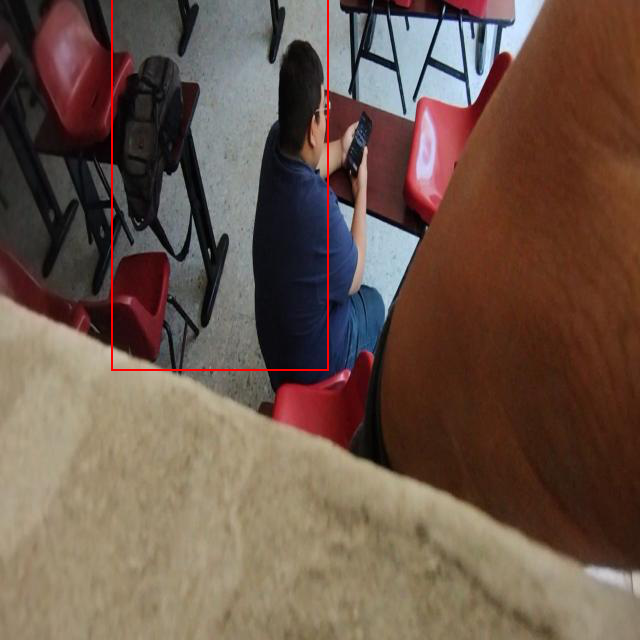

In [25]:
from PIL import Image, ImageDraw
image = Image.open(image_path4)

bbox = (output4.cpu().detach().numpy() * 640).tolist()[0]
x_center, y_center, bbox_width, bbox_height = bbox
xmin = round(x_center - (bbox_width / 2))
ymin = round(y_center - (bbox_height / 2))
xmax = round(x_center + (bbox_width / 2))
ymax = round(y_center + (bbox_height / 2))
bbox = [xmin, ymin, xmax, ymax]


draw = ImageDraw.Draw(image)


draw.rectangle(bbox, outline="red", width=2)


display(image)

[111, -23, 328, 370]


## Test with IoU

In [120]:
image_path1 = '/home/s5604009/imageextraction/data/DP/train/3ccui9ftv9dlmp8vftc2mu01v1_jpg.rf.4d1f114a372bcc2e2e4158b6d1184cfb.jpg'
image_path2='/home/s5604009/imageextraction/data/DP/train/photo-1470138831303-3e77dd49163e_jpg.rf.b332d6b84681e20b9c90251a29c91d22.jpg'

image1 = load_image_as_tensor(image_path1)
image2 = load_image_as_tensor(image_path2)

loaded_network_IoU = load_checkpoint(network,50, "/home/s5604009/imageextraction/data/DP")

loaded_network_IoU.eval()

image1 = image1.to(DEVICE)
image2 = image2.to(DEVICE)

output1 = loaded_network_IoU(image1)
output2 = loaded_network_IoU(image2)


print(output1)
print(output2)




tensor([[0.3463, 0.3234, 0.7158, 0.9024]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.3560, 0.2509, 0.7728, 0.9430]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


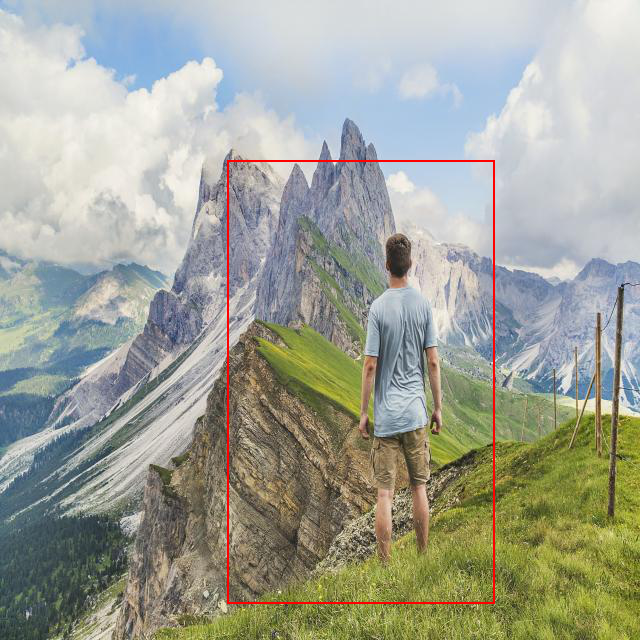

In [123]:
from PIL import Image, ImageDraw
image = Image.open(image_path2)

bbox = (output2.cpu().detach().numpy() * 640).tolist()[0]
bbox_x, bbox_y, bbox_width, bbox_height = bbox
bbox_x_max=bbox_x+bbox_width
bbox_y_max=bbox_y+bbox_height

draw = ImageDraw.Draw(image)


draw.rectangle(bbox, outline="red", width=2)


display(image)

# Unit test

In [125]:
import torch
import torch.nn.functional as F
import torch.nn as nn


import torchvision

import unittest
from PIL import Image
from torch.utils.data import DataLoader


class TestProject(unittest.TestCase):
    
      
    def test_checkpoint(self):
        model = nn.Linear(10, 2) 
        epoch = 1  
        save_dir = "saved_models"  

        if not os.path.exists(save_dir):
            os.makedirs(save_dir) 

        save_checkpoint(model, epoch, save_dir)

        expected_path = f"{save_dir}/checkpoint_{epoch}.pth"
        self.assertTrue(os.path.exists(expected_path))

        os.remove(expected_path)
        os.rmdir(save_dir)
                
    def test_image_size(self):
        test_image_path = image_path1
        image_tensor = load_image_as_tensor(test_image_path)
        self.assertEqual(image_tensor.shape[1], 3) 
        self.assertEqual(image_tensor.shape[2], 640) 
        self.assertEqual(image_tensor.shape[3], 640) 

    def test_bounding_box(self):

        image_tensor = load_image_as_tensor(image_path2)
        
        output = loaded_network_IoU(image_tensor.to("cuda"))
        print(output)
        bbox = (output.cpu().detach().numpy() * 640).tolist()[0]
        xmin, ymin, xmax, ymax = [round(coord) for coord in bbox]

        self.assertTrue(xmax > xmin)
        self.assertTrue(ymax > ymin)

    def test_batch_sizes(self):
        DATA_PATH = '/home/s5604009/imageextraction/data/DP/single_person_annotations.csv'
        batch_sz = 64

        # Load data
        train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=batch_sz)

        # Helper function to test DataLoader
        def test_dataloader(dataloader):
            for i, data in enumerate(dataloader):
                if i < len(dataloader) - 1:
                    self.assertEqual(len(data[0]), batch_sz)

        # Test each DataLoader
        test_dataloader(train_dl)
        test_dataloader(val_dl)
        test_dataloader(test_dl)

    def test_dataset_split(self):
        DATA_PATH = '/home/s5604009/imageextraction/data/DP/single_person_annotations.csv'

        train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=64)

        num_train_samples = len(train_dl.dataset)
        num_test_samples = len(test_dl.dataset)
        num_val_samples = len(val_dl.dataset)

        total_samples = len(pd.read_csv(DATA_PATH))

        ratio = (num_train_samples + num_test_samples + num_val_samples ) / total_samples

        self.assertAlmostEqual(ratio, 1.0, places=2)
        
loader = unittest.TestLoader()
suite = loader.loadTestsFromTestCase(TestProject)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)   


test_batch_sizes (__main__.TestProject.test_batch_sizes) ... ok
test_bounding_box (__main__.TestProject.test_bounding_box) ... ok
test_checkpoint (__main__.TestProject.test_checkpoint) ... ok
test_dataset_split (__main__.TestProject.test_dataset_split) ... ok
test_image_size (__main__.TestProject.test_image_size) ... ok

----------------------------------------------------------------------
Ran 5 tests in 6.217s

OK


tensor([[0.3560, 0.2509, 0.7728, 0.9430]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


<unittest.runner.TextTestResult run=5 errors=0 failures=0>